In [1]:
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/')


In [2]:
# vehicle assignment function
def veh_type_simulator(n_truck, vehicle_type_fraction): # Simulate mode choice
    choice = np.random.multinomial(n_truck, vehicle_type_fraction, size = 1)
    choice = pd.Series(choice[0])
#     print(choice)
    return(choice)

def split_dataframe(df, chunk_size = 100000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [3]:
scenario_name = 'TDA_low'
analysis_year = '2018'
output_dir = 'outputs_aus_2050'
result_dir = output_dir + '/' + analysis_year + '/' + scenario_name
# isExist = os.path.exists(result_dir)
# if not isExist:
#    # Create a new directory because it does not exist
#    os.makedirs(result_dir)
    
firms = read_csv(result_dir + '/synthetic_firms_with_fleet.csv')
private_fleet = read_csv('inputs/fleet/TX_private_fleet_size_distribution_V2.csv')
for_hire_fleet = read_csv('inputs/fleet/TX_for_hire_fleet_size_distribution_V2.csv')
for_lease_fleet = read_csv('inputs/fleet/TX_for_lease_fleet_size_distribution_V2.csv')
cargo_type_distribution = read_csv("inputs/fleet/probability_of_cargo_group.csv")

# forecast values
national_fleet_composition = read_csv('inputs/fleet/' + scenario_name + '/TDA_vehicle_stock.csv')
vehicle_type_by_state = read_csv('inputs/fleet/' + scenario_name + '/fleet_composition_by_state.csv')
ev_fraction = read_csv('inputs/fleet/' + scenario_name + '/EV_fraction_by_type.csv')
ev_availability = read_csv('inputs/fleet/' + scenario_name + '/EV_availability.csv')

state_fips_lookup = read_csv('inputs/us-state-ansi-fips.csv')

payload_capacity = {'Class 4-6 Vocational': 4,
                   'Class 7&8 Tractor': 18,
                   'Class 7&8 Vocational': 18}

ev_availability.head(5)
# vehicle_type_fraction = [0.206287,	0.505178, 0.244464, 0.044071]  # will be replaced once input from Alicia is ready

,Year,vehicle type,Powertrain,Stock,EV_fraction
0,2018,Class 4-6 Vocational,Battery Electric,101.0,1.0
1,2018,Class 4-6 Vocational,H2 Fuel Cell,0.0,0.0
2,2018,Class 4-6 Vocational,PHEV Diesel,0.0,0.0
3,2018,Class 4-6 Vocational,PHEV Gasoline,0.0,0.0
4,2018,Class 7&8 Tractor,Battery Electric,6.0,1.0


In [4]:
# filter vehicle composition data

vehicle_type_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Year'] == int(analysis_year)]

national_fleet_composition = \
national_fleet_composition.loc[national_fleet_composition['Year'] == int(analysis_year)]

ev_fraction = ev_fraction.loc[ev_fraction['Year'] == int(analysis_year)]

ev_availability = ev_availability.loc[ev_availability['Year'] == int(analysis_year)]

ev_availability.head(5)

,Year,vehicle type,Powertrain,Stock,EV_fraction
0,2018,Class 4-6 Vocational,Battery Electric,101.0,1.0
1,2018,Class 4-6 Vocational,H2 Fuel Cell,0.0,0.0
2,2018,Class 4-6 Vocational,PHEV Diesel,0.0,0.0
3,2018,Class 4-6 Vocational,PHEV Gasoline,0.0,0.0
4,2018,Class 7&8 Tractor,Battery Electric,6.0,1.0


In [5]:
# load b2b output
combined_b2b_flow = None
dir_to_outputs = 'outputs_aus_2050'
for i in range(5):
    sctg = i + 1
    sctg_code = 'sctg' + str(sctg)
    file_dir = dir_to_outputs + '/' + sctg_code + '_truck/'
    filelist = [file for file in os.listdir(file_dir) if (file.endswith('.csv'))]
    print(sctg_code)
    combined_csv = pd.concat([read_csv(file_dir + f, low_memory=False) for f in filelist ])
    combined_csv = combined_csv.loc[combined_csv['mode_choice'] == 'Private Truck']
    combined_b2b_flow = pd.concat([combined_b2b_flow, combined_csv])
#     break
combined_b2b_flow.head(5)

sctg1
sctg2
sctg3
sctg4
sctg5


,BuyerID,BuyerZone,BuyerNAICS,SellerID,SellerZone,SellerNAICS,TruckLoad,SCTG_Group,shipment_id,orig_FAFID,dest_FAFID,mode_choice,probability,Distance,Travel_time
1,725129,1165,230301,121345,739,212310.0,35.535029,1,9000002,488,488,Private Truck,0.408466,0.0,4.0
2,725129,1165,230301,121345,739,212310.0,35.535029,1,9000003,488,488,Private Truck,0.408466,0.0,4.0
4,725129,1165,230301,121345,739,212310.0,35.535029,1,9000005,488,488,Private Truck,0.408466,0.0,4.0
5,725129,1165,230301,121345,739,212310.0,35.535029,1,9000006,488,488,Private Truck,0.408466,0.0,4.0
7,725129,1165,230301,121345,739,212310.0,35.535029,1,9000008,488,488,Private Truck,0.408466,0.0,4.0


<AxesSubplot:>

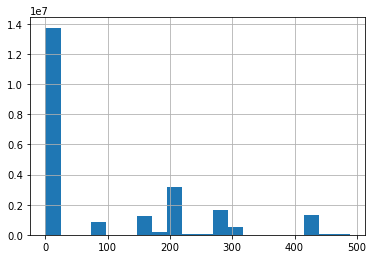

In [6]:
combined_b2b_flow.Distance.hist(bins = 20)

In [7]:
# select firms with private truck shipment
selected_firms_with_load = combined_b2b_flow.groupby(['SellerID'])[['TruckLoad']].sum()
selected_firms_with_load = selected_firms_with_load.reset_index()
selected_firms_with_load.columns = ['BusID', 'Production']
print(len(selected_firms_with_load))
selected_firms_with_load.head(5)

8972


,BusID,Production
0,1018,38664.451929
1,1154,9826.713959
2,1156,44.910000
3,2399,18164.187969
4,2402,113.743606


In [8]:
# separate firms with/without private truck shipment
print(len(firms))
selected_sellers = selected_firms_with_load.BusID.unique()
firms_without_adj = firms.loc[~firms['BusID'].isin(selected_sellers)]
firms_with_adj = pd.merge(firms, selected_firms_with_load,
                          on = 'BusID', how = 'inner')
print(len(firms_without_adj))
print(len(firms_with_adj))
firms_with_adj.head(5)

14315456
14298781
16675


,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,fleet_id,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,n_trucks,Production
0,4065962,1,49,222,1111B0,2,1.927641,8406405,20049.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31041.337845
1,4080511,1,49,222,4A0000,0,6.689992,8406405,20049.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31041.337845
2,4080512,1,49,222,4A0000,0,6.689992,8406405,20049.0,0.0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31041.337845
3,4080513,1,49,222,4A0000,0,6.689992,8406405,20049.0,0.0,...,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31041.337845
4,4065993,1,49,222,1111B0,2,2.243243,8405905,20049.0,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,453.793557


In [9]:
# format fleet composition
list_of_veh_tech = vehicle_type_by_state['vehicle category'].unique().tolist()

private_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'PRIVATE']
private_fleet_by_state_wide = pd.pivot_table(private_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
private_fleet_by_state_wide = private_fleet_by_state_wide.reset_index()


for_hire_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'FOR HIRE']
for_hire_fleet_by_state_wide = pd.pivot_table(for_hire_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_hire_fleet_by_state_wide = for_hire_fleet_by_state_wide.reset_index()


for_lease_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'LEASE']
for_lease_fleet_by_state_wide = pd.pivot_table(for_lease_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_lease_fleet_by_state_wide = for_lease_fleet_by_state_wide.reset_index()

private_fleet_by_state_wide.head(5)

vehicle category,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,ALABAMA,0.243046,0.303801,0.282828,0.000012,6.467405e-07,2.889022e-07,0.169764
1,ALASKA,0.275343,0.221711,0.309854,0.000014,4.719849e-07,3.165081e-07,0.192323
2,ARIZONA,0.274482,0.308356,0.224665,0.000013,6.564382e-07,2.294897e-07,0.191722
3,ARKANSAS,0.158329,0.538997,0.191483,0.000008,1.147434e-06,1.955959e-07,0.110591
4,CALIFORNIA,0.279156,0.327610,0.197732,0.000014,6.974263e-07,2.019784e-07,0.194987


In [10]:
print(firms_with_adj.columns)
firms_with_adj = firms_with_adj[['esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'Production']]

firms_with_adj = firms_with_adj.drop_duplicates(subset = 'BusID',
                                                keep = 'first')
print(len(firms_with_adj))
print(len(firms_with_adj.BusID.unique()))
firms_with_adj.head(5)

Index(['Unnamed: 0', 'esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'st',
       'stname', 'EV_powertrain (if any)', 'fleet_id',
       'Diesel Class 4-6 Vocational', 'Diesel Class 7&8 Tractor',
       'Diesel Class 7&8 Vocational', 'Electric Class 4-6 Vocational',
       'Electric Class 7&8 Tractor', 'Electric Class 7&8 Vocational',
       'Gasoline Class 4-6 Vocational', 'n_trucks', 'Production'],
      dtype='object')
8941
8941


,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,Production
0,1,49,222,1111B0,2,1.927641,8406405,20049.0,0.0,0.0,31041.337845
4,1,49,222,1111B0,2,2.243243,8405905,20049.0,0.0,0.0,453.793557
9,1,49,222,1111B0,2,4.920814,8406009,20049.0,0.0,0.0,517.798440
16,1,49,222,1111B0,2,5.600000,8405866,20049.0,0.0,0.0,284.818532
21,1,49,222,111200,3,7.882353,8406013,20049.0,0.0,0.0,162.513600


8941


,fleet_size,min_size,fraction_of_carrier,avg_truck_per_carrier,total_truck_std,n_trucks
0,0-2,1,0.709745,1.218434,0.413643,1
0,0-2,1,0.709745,1.218434,0.413643,2
0,0-2,1,0.709745,1.218434,0.413643,2
0,0-2,1,0.709745,1.218434,0.413643,1
0,0-2,1,0.709745,1.218434,0.413643,2


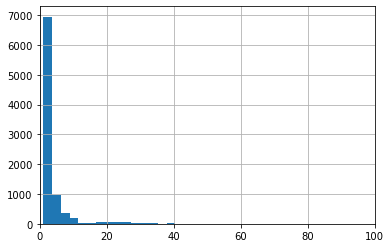

In [11]:
# re-generate fleet size for selected firms
sample_size = len(firms_with_adj)
# print(tx_private_fleet.columns)
private_fleet_short = private_fleet[['fleet_size', 'min_size', 
                                    'fraction_of_carrier', 
                                    'avg_truck_per_carrier', 
                                    'total_truck_std']]

firm_fleet_sample = \
private_fleet_short.sample(n = sample_size,
                           weights = private_fleet_short['fraction_of_carrier'],
                           replace = True)
print(len(firm_fleet_sample))
# generate random fleet size
firm_fleet_sample.loc[:, 'n_trucks'] = np.random.normal(loc = firm_fleet_sample.loc[:, 'avg_truck_per_carrier'],
                                                   scale = firm_fleet_sample.loc[:, 'total_truck_std'])
criteria = (firm_fleet_sample['n_trucks'] <= 1)
firm_fleet_sample.loc[criteria, 'n_trucks'] = 1
firm_fleet_sample.loc[:, 'n_trucks'] = np.round(firm_fleet_sample.loc[:, 'n_trucks'], 0)
firm_fleet_sample.loc[:, 'n_trucks'] = firm_fleet_sample.loc[:, 'n_trucks'].astype(int)

firm_fleet_sample['n_trucks'].hist(bins = 1000)
plt.xlim([0,100])
firm_fleet_sample.head(5)

In [12]:
# append vehicle composition to firms by state
firm_fleet_sample = firm_fleet_sample.sort_values(by = ['n_trucks'], ascending = True)
firms_with_adj = firms_with_adj.sort_values(by = ['Production'], ascending = True)

firm_fleet_sample_short = firm_fleet_sample[['n_trucks']]

firms_with_fleet = pd.concat([firms_with_adj.reset_index(drop=True), 
                              firm_fleet_sample_short.reset_index(drop=True)], axis=1)

firms_with_fleet.loc[:, 'FAFZONE'] = firms_with_fleet.loc[:,'FAFZONE'].astype(str).str.zfill(3)
firms_with_fleet.loc[:, 'st'] = firms_with_fleet.loc[:, 'FAFZONE'].str[:2]
firms_with_fleet.loc[:, 'st'] = firms_with_fleet.loc[:, 'st'].astype(int)

firms_with_fleet = pd.merge(firms_with_fleet, state_fips_lookup,
                            on = 'st', how = 'left')

firms_with_fleet.loc[:,'stname'] = firms_with_fleet.loc[:,'stname'].str.upper()

firms_with_fleet = pd.merge(firms_with_fleet, private_fleet_by_state_wide,
                            left_on = 'stname', right_on = 'state', how = 'left')

firms_with_fleet.head(5)

,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,2,48177,489,424700,18,0.655193,1474981,2775.0,0.0,0.0,...,TEXAS,TX,TEXAS,0.191381,0.482841,0.191899,0.000009,1.027888e-06,1.960198e-07,0.133677
1,1,48347,489,311615,5,0.006244,865049,4617.0,0.0,0.0,...,TEXAS,TX,TEXAS,0.191381,0.482841,0.191899,0.000009,1.027888e-06,1.960198e-07,0.133677
2,1,48389,489,424700,17,0.382578,1471307,4995.0,0.0,0.0,...,TEXAS,TX,TEXAS,0.191381,0.482841,0.191899,0.000009,1.027888e-06,1.960198e-07,0.133677
3,1,49,222,531000,0,1.880000,8405961,20049.0,0.0,0.0,...,LOUISIANA,LA,LOUISIANA,0.209896,0.385774,0.257451,0.000010,8.212483e-07,2.629806e-07,0.146610
4,1,48003,489,424700,18,0.500000,1476966,47.0,0.0,0.0,...,TEXAS,TX,TEXAS,0.191381,0.482841,0.191899,0.000009,1.027888e-06,1.960198e-07,0.133677


In [13]:
# assign vehicle technology
chunks = split_dataframe(firms_with_fleet)
i = 0
var_to_keep = ['esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'n_trucks',
       'st', 'stname']

for chunk in chunks:
    print('processing chunk ' + str(i))
    chunk[list_of_veh_tech] = \
    chunk.apply(
            lambda row: veh_type_simulator(row['n_trucks'], row[list_of_veh_tech]), axis=1, result_type ='expand')
    # print(np.random.multinomial(testing_fleet_sample['n_trucks'], vehicle_type_fraction))
    chunk = pd.melt(chunk, id_vars = var_to_keep, 
                    value_vars = list_of_veh_tech, 
                   var_name = 'veh_type',
                   value_name = 'number_of_veh')
    chunk = chunk.reset_index()
    chunk = chunk.loc[chunk['number_of_veh'] > 0]
    chunk.loc[:, 'fleet_id']=chunk.groupby('BusID').cumcount() + 1
    if i==0:
        firms_with_fleet = chunk
    else:
        firms_with_fleet = pd.concat([firms_with_fleet, chunk])
    i += 1
firms_with_fleet.head(5)

processing chunk 0


,index,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,n_trucks,st,stname,veh_type,number_of_veh,fleet_id
4,4,1,48003,489,424700,18,0.500000,1476966,47.0,0.0,0.0,1,48,TEXAS,Diesel Class 4-6 Vocational,1,1
6,6,1,48029,488,423100,36,7.710017,1152857,1297.0,0.0,0.0,1,48,TEXAS,Diesel Class 4-6 Vocational,1,1
7,7,2,48027,489,423100,36,1.000000,1162792,381.0,0.0,0.0,1,48,TEXAS,Diesel Class 4-6 Vocational,1,1
11,11,2,48307,489,423800,34,1.000000,1302589,4177.0,0.0,0.0,1,48,TEXAS,Diesel Class 4-6 Vocational,1,1
16,16,1,114,486,424700,18,2.570673,1478464,20114.0,0.0,0.0,1,48,TEXAS,Diesel Class 4-6 Vocational,1,1


In [14]:
# assign EV powertrain
body_types = ev_availability['vehicle type'].unique()
firms_with_fleet.loc[:, 'EV_powertrain (if any)'] = np.nan

firms_with_fleet_out = None

for bt in body_types:
    print(bt)
    vehicle_capacity = payload_capacity[bt]
    ev_availability_select = \
    ev_availability.loc[ev_availability['vehicle type'] == bt]
    powertrain = ev_availability_select.Powertrain.to_numpy()
    probability = ev_availability_select.EV_fraction.to_numpy()
    
    firm_to_assign = \
    firms_with_fleet.loc[firms_with_fleet['veh_type'].str.contains(bt)].reset_index()    
    sample_size_1 = len(firm_to_assign)
    firm_to_assign.loc[:, 'EV_powertrain (if any)'] = \
    pd.Series(np.random.choice(powertrain, size = sample_size_1, p=probability) )
    
    firm_to_assign.loc[firm_to_assign['EV_powertrain (if any)'].isin(['PHEV Diesel', 'PHEV Gasoline']), 'EV_powertrain (if any)'] = 'PHEV'
    firm_to_assign.loc[:, 'veh_capacity'] = \
    firm_to_assign.loc[:, 'number_of_veh'] * vehicle_capacity
    firms_with_fleet_out = pd.concat([firms_with_fleet_out, firm_to_assign])

firms_with_fleet_out.head(5)

Class 4-6 Vocational
Class 7&8 Tractor
Class 7&8 Vocational


,level_0,index,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,n_trucks,st,stname,veh_type,number_of_veh,fleet_id,EV_powertrain (if any),veh_capacity
0,4,4,1,48003,489,424700,18,0.500000,1476966,47.0,0.0,0.0,1,48,TEXAS,Diesel Class 4-6 Vocational,1,1,Battery Electric,4
1,6,6,1,48029,488,423100,36,7.710017,1152857,1297.0,0.0,0.0,1,48,TEXAS,Diesel Class 4-6 Vocational,1,1,Battery Electric,4
2,7,7,2,48027,489,423100,36,1.000000,1162792,381.0,0.0,0.0,1,48,TEXAS,Diesel Class 4-6 Vocational,1,1,Battery Electric,4
3,11,11,2,48307,489,423800,34,1.000000,1302589,4177.0,0.0,0.0,1,48,TEXAS,Diesel Class 4-6 Vocational,1,1,Battery Electric,4
4,16,16,1,114,486,424700,18,2.570673,1478464,20114.0,0.0,0.0,1,48,TEXAS,Diesel Class 4-6 Vocational,1,1,Battery Electric,4


In [15]:
# format data
index_var = ['esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon',
            'st', 'stname', 'EV_powertrain (if any)', 'fleet_id', 'veh_capacity']

avail_veh_tech = firms_with_fleet_out.veh_type.unique()
firms_with_fleet_out = firms_with_fleet_out.pivot(values = 'number_of_veh',
                               index = index_var, columns = 'veh_type')
firms_with_fleet_out = firms_with_fleet_out.reset_index()
firms_with_fleet_out = firms_with_fleet_out.fillna(0)
firms_with_fleet_out.loc[:, 'n_trucks'] = \
firms_with_fleet_out.loc[:, avail_veh_tech].sum(axis = 1)
firms_with_fleet_out.head(5)

veh_type,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,EV_powertrain (if any),fleet_id,veh_capacity,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,n_trucks
0,1,49,222,1111B0,2,1.927641,8406405,20049.0,0.0,0.0,...,Battery Electric,1,72,0.0,4.0,0.0,0.0,0.0,0.0,4.0
1,1,49,222,1111B0,2,1.927641,8406405,20049.0,0.0,0.0,...,Battery Electric,2,36,0.0,0.0,2.0,0.0,0.0,0.0,2.0
2,1,49,222,1111B0,2,2.243243,8405905,20049.0,0.0,0.0,...,Battery Electric,1,18,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,49,222,1111B0,2,4.920814,8406009,20049.0,0.0,0.0,...,Battery Electric,1,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,49,222,1111B0,2,5.600000,8405866,20049.0,0.0,0.0,...,Battery Electric,1,18,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [16]:
# assign fleet to private truck shipments
firms_with_fleet_short = firms_with_fleet_out[['BusID', 'fleet_id', 'veh_capacity']]
firms_with_fleet_short.loc[:, 'pdf'] = \
firms_with_fleet_short.loc[:, 'veh_capacity'] / \
firms_with_fleet_short.groupby('BusID')['veh_capacity'].transform('sum')
firms_with_fleet_short.loc[:, 'cdf'] = \
firms_with_fleet_short.groupby('BusID')['pdf'].cumsum()
firms_with_fleet_short.head(5)

# load b2b output
# combined_b2b_flow = None
# dir_to_outputs = 'mode_choice/outputs'

for i in range(5):
    sctg = i + 1
    sctg_code = 'sctg' + str(sctg)
    file_dir = dir_to_outputs + '/' + sctg_code + '_truck/'

    filelist = [file for file in os.listdir(file_dir) if (file.endswith('.csv'))]
    print(sctg_code)
    combined_csv = pd.concat([read_csv(file_dir + f, low_memory=False) for f in filelist ])
    private_truck = combined_csv.loc[combined_csv['mode_choice'] == 'Private Truck']
    for_hire_truck = combined_csv.loc[combined_csv['mode_choice'] != 'Private Truck']
    sample_size = len(private_truck)
    if sample_size > 0:
        private_truck.loc[:, 'rand'] = pd.Series(np.random.uniform(size = sample_size))
        private_truck = pd.merge(private_truck, firms_with_fleet_short,
                                left_on = 'SellerID', right_on = 'BusID',
                                how = 'left')
        private_truck.loc[:, 'indicator'] = 0
        criteria = (private_truck.loc[:, 'rand'] < private_truck.loc[:, 'cdf'])
        private_truck.loc[criteria, 'indicator'] = 1
        private_truck = private_truck.loc[private_truck['indicator'] == 1]
        private_truck = private_truck.drop_duplicates(subset = 'shipment_id', keep = 'first')
        print(sample_size, len(private_truck))
        private_truck = private_truck.drop(columns=['rand',	'BusID', 'veh_capacity', 'pdf', 'cdf', 'indicator'])
        private_truck.to_csv(result_dir +  '/private_truck_shipment_' + sctg_code +  '.csv')
    if len(for_hire_truck) > 0:
        for_hire_truck.to_csv(result_dir +  '/for_hire_truck_shipment_' + sctg_code + '.csv')
    
#     break
#     combined_b2b_flow = pd.concat([combined_b2b_flow, combined_csv])
#     break
# combined_b2b_flow.head(5)
private_truck.head(5)

sctg1
1935808 1930948
sctg2
5745512 5693682
sctg3
2139147 2138500
sctg4
13047587 13047424
sctg5
86049 13618


,BuyerID,BuyerZone,BuyerNAICS,SellerID,SellerZone,SellerNAICS,TruckLoad,SCTG_Group,shipment_id,orig_FAFID,dest_FAFID,mode_choice,probability,Distance,Travel_time,fleet_id
2,6343032,4165,624A00,1014495,20114,332500.0,18.47021,5,4387,486,489,Private Truck,0.139744,424.09,22.524462,3
7,6343032,4165,624A00,1014495,20114,332500.0,18.47021,5,4389,486,489,Private Truck,0.139744,424.09,22.524462,4
10,6343032,4165,624A00,1014495,20114,332500.0,18.47021,5,4397,486,489,Private Truck,0.139744,424.09,22.524462,3
14,6343032,4165,624A00,1014495,20114,332500.0,18.47021,5,4398,486,489,Private Truck,0.139744,424.09,22.524462,3
18,6343032,4165,624A00,1014495,20114,332500.0,18.47021,5,4415,486,489,Private Truck,0.139744,424.09,22.524462,3


In [17]:
print(firms_without_adj.columns)
print(firms_with_fleet_out.columns)
firms_with_fleet_out = firms_with_fleet_out.drop(columns=['veh_capacity'])
firms_output = pd.concat([firms_with_fleet_out, firms_without_adj])

Index(['Unnamed: 0', 'esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'st',
       'stname', 'EV_powertrain (if any)', 'fleet_id',
       'Diesel Class 4-6 Vocational', 'Diesel Class 7&8 Tractor',
       'Diesel Class 7&8 Vocational', 'Electric Class 4-6 Vocational',
       'Electric Class 7&8 Tractor', 'Electric Class 7&8 Vocational',
       'Gasoline Class 4-6 Vocational', 'n_trucks'],
      dtype='object')
Index(['esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'st',
       'stname', 'EV_powertrain (if any)', 'fleet_id', 'veh_capacity',
       'Diesel Class 4-6 Vocational', 'Diesel Class 7&8 Tractor',
       'Diesel Class 7&8 Vocational', 'Electric Class 4-6 Vocational',
       'Electric Class 7&8 Vocational', 'Gasoline Class 4-6 Vocational',
       'n_trucks'],
      dtype='object', name='veh_type')


In [18]:
print(len(firms_without_adj)+len(firms_with_fleet))
print(len(firms_output))

14313634
14313634


In [19]:
# writing output
firms_output.to_csv(result_dir + '/synthetic_firms_with_fleet_mc_adjusted.csv')